# Programming Exercise 3: Multi-class Classification and Neural Networks

## Introduction
In this exercise, you will implement one-vs-all logistic regression and neural networks to recognize hand-written digits. Before starting the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics. 


In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from math import floor, sqrt, ceil

%matplotlib inline

## 1 Multi-class Classification
For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you've learned can be used for this classification task.

In the first part of the exercise, you will extend your previous implemention of logistic regression and apply it to one-vs-all classification 

### 1.1 Dataset
You are given a data set that contains 5000 training examples of handwritten digits. The .mat format means that that the data has been saved in a native Octave/MATLAB matrix format, instead of a text (ASCII) format like a csv-file. These matrices can be read directly into your program by using the load command. After loading, matrices of the correct dimensions and values will appear in your program's memory. The matrix will already be named, so you do not need to assign names to them.

In [2]:
#import numpy as np
#import h5py 
#f = h5py.File('ex3data1.mat','r') 
# The matrices X and y will now be in your Octave environment

import scipy.io
mat = scipy.io.loadmat('ex3data1.mat')
X = np.matrix(mat.get('X'))
y = mat.get('y')

# reposition index of 0 as 0 instead of 10
y[np.flatnonzero(y==10)] = 0

There are 5000 training examples in ex3data1.mat, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a  oating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is "unrolled" into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix}
           - (x^{(1)})^T - \\
           - (x^{(2)})^T - \\
           \vdots \\
           - (x^{(m)})^T - \\
         \end{bmatrix}$$
         
The second part of the training set is a 5000-dimensional vector y that contains labels for the training set. We have mapped the digit zero to the value ten.

### 1.2 Visualizing the data
You will begin by visualizing a subset of the training set. In Part 1 of ex3.m, the code randomly selects selects 100 rows from X and passes those rows to the displayData function. This function maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together. We have provided the displayData function, and you are encouraged to examine the code to see how it works. After you run this step, you should see an image like Figure 1.

In [3]:
def displayData(X):
    
    m = X.shape[0]
    plt.figure()
    
    if(m == 1):
        tmp = X[0,:].reshape(20,20, order='F')
        plt.imshow(tmp, cmap='gray_r')
    else:
        display_rows = floor(sqrt(m))
        display_cols = ceil(m / display_rows)
        # set up array
        fig, axarr = plt.subplots(nrows=display_rows, ncols=display_cols,
                                  figsize=(10,10))

        # loop over randomly drawn numbers
        for ii in range(display_rows):
            for jj in range(display_cols):
                tmp = X[ii*display_cols+jj,:].reshape(20,20, order='F')
                axarr[ii,jj].imshow(tmp, cmap='gray_r')
                plt.setp(axarr[ii,jj].get_xticklabels(), visible=False)
                plt.setp(axarr[ii,jj].get_yticklabels(), visible=False)

        fig.subplots_adjust(hspace=0, wspace=0)

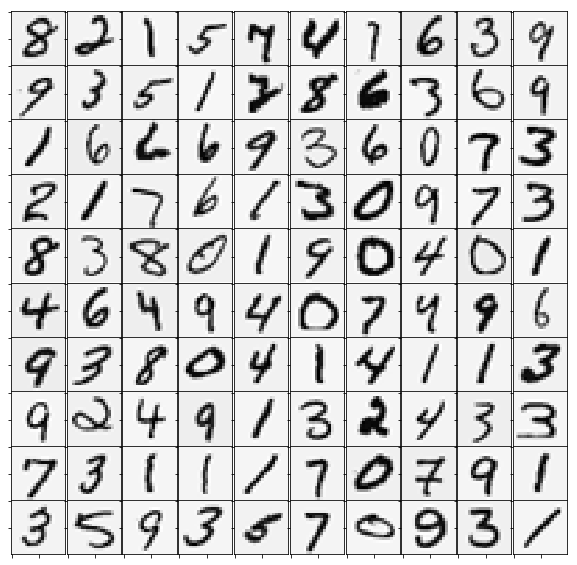

In [4]:
m, n = X.shape

rand_indices = np.random.permutation(m)
sel = X[rand_indices[0:100], :]

displayData(sel)

## 1.3 Vectorizing Logistic Regression
You will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, you will need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that your code is well vectorized. In this section, you will implement a vectorized version of logistic regression that does not  employ any for loops. You can use your code in the last exercise as a starting point for this exercise.

#### 1.3.1 Vectorizing the cost function
We will begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is
$$ J(\theta)=\frac{1}{m}\sum^{m}_{i=1}[-y^{(i)}log(h_\theta(x^{(i)})) - (1-y^{(i)})log(1-h_\theta(x^{(i)}))] $$

To compute each element in the summation, we have to compute $h\theta(x^{(i)})$ for every example i, where $h_\theta(x^{(i)})$ = $g(\theta^T x^{(i)})$ and $g(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function. It turns out that we can compute this quickly for all our examples by using matrix multiplication. Let us define X and $\theta$ as 
$$ X = \begin{bmatrix}
           - (x^{(1)})^T - \\
           - (x^{(2)})^T - \\
           \vdots \\
           - (x^{(m)})^T - \\
         \end{bmatrix}
         \mbox{  and  }
         \theta = \begin{bmatrix}
           \theta_0 \\
           \theta_1 \\
           \vdots \\
           \theta_n \\
         \end{bmatrix}
         $$ 

Then, by computing the matrix product $X\theta$, we have

$$ X\theta = \begin{bmatrix}
           - (x^{(1)})^T\theta - \\
           - (x^{(2)})^T\theta - \\
           \vdots \\
           - (x^{(m)})^T\theta - \\
         \end{bmatrix}
         = \begin{bmatrix}
           - \theta^T(x^{(1)}) - \\
           - \theta^T(x^{(2)}) - \\
           \vdots \\
           - \theta^T(x^{(m)}) - \\
         \end{bmatrix}
         $$ 
         
In the last equality, we used the fact that $a^Tb = b^Ta$ if a and b are vectors. This allows us to compute the products $\theta^T x^{(i)}$ for all our examples i in one line of code.

Your job is to write the unregularized cost function in the file lrCostFunction.m Your implementation should use the strategy we presented above to calculate $\theta^T x^{(i)}$. You should also use a vectorized approach for the rest of the cost function. A fully vectorized version of lrCostFunction.m should not contain any loops.



#### 1.3.2 Vectorizing the gradient
Recall that the gradient of the (unregularized) logistic regression cost is a vector where the jth element is defined as
$$\frac{\partial J(\theta)}{\partial \theta_j}=\frac{1}{m}\sum\limits^{m}_{i=1}(h_\theta(x^{(i)})-y^{(i)})x^{(i)}_j$$

To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $\theta_j$ ,

$$ X\theta = \begin{bmatrix}
               \frac{\partial J}{\partial \theta_0} \\
               \frac{\partial J}{\partial \theta_1} \\
               \frac{\partial J}{\partial \theta_2} \\
               \vdots \\
               \frac{\partial J}{\partial \theta_n} \\
         \end{bmatrix}
         = \frac{1}{m}\begin{bmatrix}
               \sum^{m}_{i=1}((h_\theta(x^{(i)}-y^{(i)})x_0^{(i)}) \\
               \sum^{m}_{i=1}((h_\theta(x^{(i)}-y^{(i)})x_1^{(i)}) \\
               \sum^{m}_{i=1}((h_\theta(x^{(i)}-y^{(i)})x_2^{(i)}) \\
               \vdots \\
               \sum^{m}_{i=1}((h_\theta(x^{(i)}-y^{(i)})x_n^{(i)}) \\
         \end{bmatrix}
         = \frac{1}{m}\sum^{m}_{i=1}((h_\theta(x^{(i)}-y^{(i)})x^{(i)})
         = \frac{1}{m}X^T(h_\theta(x)-y)
         $$ 


Note that $x^{(i)}$ is a vector, while $(h\theta(x^{(i)}) -y^{(i)})$ is a scalar (single number). To understand the last step of the derivation, let $\beta_i = (h_\theta(x^{(i)}) - y^{(i)})$ and
observe that:

$$ \sum_i \beta_i x^{(i)} = \begin{bmatrix}
| & |  &  & |  \\
x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\
| & |  &  & |  \\
\end{bmatrix} 
\begin{bmatrix}
    \beta_1 \\
    \beta_2 \\
    \vdots \\
    \beta_m \\
    \end{bmatrix} = X^T\beta$$
    
where the values $\beta_i = (h_\theta(x^{(i)}) - y^{(i)})$. The expression above allows us to compute all the partial derivatives without any loops. If you are comfortable with linear algebra, we encourage you to work through the matrix multiplications above to convince yourself that the vectorized version does the same computations. You should now implement Equation 1 to compute the correct vectorized gradient. Once you are done, complete the function lrCostFunction.m by implementing the gradient.


#### 1.3.3 Vectorizing regularized logistic regression
After you have implemented vectorization for logistic regression, you will now add regularization to the cost function. Recall that for regularized logistic
regression, the cost function is defined as

$$ J(\theta)=\frac{1}{m}\sum^{m}_{i=1}[-y^{(i)}log(h_\theta(x^{(i)})) - (1-y^{(i)})log(1-h_\theta(x^{(i)}))] + \frac{\lambda}{2m}\sum^{n}_{j=1}\theta^2_j $$

Note that you should not be regularizing $\theta_0$ which is used for the bias term.
Correspondingly, the partial derivative of regularized logistic regression cost for $\theta_j$ is defined as 
$$ 
\begin{align}
\frac{\partial J(\theta)}{\partial \theta_j}=\frac{1}{m}\sum\limits^{m}_{i=1}(h_\theta(x^{(i)})-y^{(i)})x^{(i)}_j & & \mbox{ for $j=0$} \\
\frac{\partial J(\theta)}{\partial \theta_j}=(\frac{1}{m}\sum\limits^{m}_{i=1}(h_\theta(x^{(i)})-y^{(i)})x^{(i)}_j) + \frac{\lambda}{m}\theta_j & & \mbox{ for $j>=1$}
\end{align}
$$ 

Now modify your code in lrCostFunction to account for regularization. Once again, you should not put any loops into your code.

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Take the following parameters and return the cost and gradient
# theta = 1 X m, X = n X m, and y = 1 X n (m = no. of feature and n = no. of sample)
# cost = R
def cost_func_reg(theta, X, y, l):
    theta = np.asarray(np.matrix(theta).T)
    mask_array = np.ones((len(theta), 1))
    mask_array[0,0] = 0.0
    
    with np.errstate(divide='ignore'):
        m = len(y)  
        htheta = sigmoid(np.matmul(X, theta))
        # use auxiliary gradient function
        # use auxiliary cost function
        J = - 1 / m * (np.matmul(y.T, np.log(htheta)) + np.matmul((1-y).T, np.log(1-htheta))) \
                + l/2/m*np.sum(np.multiply(mask_array, theta)**2)
        return J

# Take the following parameters and return the cost and gradient
# theta = 1 X m, X = n X m, and y = 1 X n (m = no. of feature and n = no. of sample)
# grad = 1 X m
def gradient_func_reg(theta, X, y, l):
    theta = np.asarray(np.matrix(theta).T)
    mask_array = np.ones((len(theta), 1))
    mask_array[0, 0] = 0.0
    
    with np.errstate(divide='ignore'):
        m = len(y)  
        htheta = sigmoid(np.matmul(X, theta))
        
        grad = np.matmul(X.T, (htheta - y)) / m + np.multiply(mask_array, theta) * l / m
        grad = grad.A1
        return grad

# Take the following parameters and return the cost and gradient
# theta = m X 1, X = n X m, and y = n X 1 (m = no. of feature and n = no. of sample)
# cost = const and gradient = m X 1
def lrCostFunction(theta, X, y, l):
    mask_array = np.ones((len(theta), 1))
    mask_array[0,0] = 0.0
    with np.errstate(divide='ignore'):
        m = len(y)  
        htheta = sigmoid(np.matmul(X, theta))
        # use auxiliary cost function
        J = - 1 / m * (np.matmul(y.T, np.log(htheta)) + np.matmul((1-y).T, np.log(1-htheta))) \
                + l/2/m*np.sum(np.multiply(mask_array, theta)**2)

        # use auxiliary gradient function
        grad = np.matmul(X.T, (htheta - y)) / m + np.multiply(mask_array, theta) * l / m
    
        return J, grad

In [6]:
# ============ Part 2a: Vectorize Logistic Regression ============
#  In this part of the exercise, you will reuse your logistic regression
#  code from the last exercise. You task here is to make sure that your
#  regularized logistic regression implementation is vectorized. After
#  that, you will implement one-vs-all classification for the handwritten
#  digit dataset.
#

# Test case for lrCostFunction
print('\nTesting lrCostFunction() with regularization');

theta_t = np.array([[-2, -1, 1, 2]]).T
X_t = np.hstack([np.ones((5,1)), np.reshape(np.arange(1, 16),(5,3), order='F')/10])
y_t =  np.array([[1, 0, 1, 0, 1]]).T >= 0.5
lambda_t = 3
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('\nCost: %f\n' % J);
print('Expected cost: 2.534819\n');
print('Gradients:\n');
print(grad);
print('Expected gradients:\n');
print(' 0.146561\n -0.548558\n 0.724722\n 1.398003\n');


Testing lrCostFunction() with regularization

Cost: 2.534819

Expected cost: 2.534819

Gradients:

[[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]]
Expected gradients:

 0.146561
 -0.548558
 0.724722
 1.398003



### 1.4 One-vs-all Classification
In this part of the exercise, you will implement one-vs-all classication by training multiple regularized logistic regression classifiers, one for each of the K classes in our dataset (Figure 1). In the handwritten digits dataset, K = 10, but your code should work for any value of K.

You should now complete the code in oneVsAll.m to train one classifier for each class. In particular, your code should return all the classifier parameters in a matrix $\Theta \in \Bbb{R}^{K\times(N+1)} $ , where each row of $\Theta$ corresponds to the learned logistic regression parameters for one class. You can do this with a \for"-loop from 1 to K, training each classifier independently.

Note that the y argument to this function is a vector of labels from 1 to 10, where we have mapped the digit "0" to the label 10 (to avoid confusions with indexing). 

When training the classifier for class $k \in \{1, ..., K\}$, you will want a m-dimensional vector of labels y, where $y \in 0, 1$ indicates whether the j-th training instance belongs to class $k$ $(y_j = 1)$, or if it belongs to a different class $(y_j = 0)$. You may find logical arrays helpful for this task.

Furthermore, you will be using fmincg for this exercise (instead of fminunc). fmincg works similarly to fminunc, but is more more efficient for dealing with a large number of parameters. After you have correctly completed the code for oneVsAll.m, the script ex3.m will continue to use your oneVsAll function to train a multi-class classifier.

In [7]:
def oneVsAll(X, y, num_labels, lambda_t):
#ONEVSALL trains multiple logistic regression classifiers and returns all
#the classifiers in a matrix all_theta, where the i-th row of all_theta 
#corresponds to the classifier for label i
#   [all_theta] = ONEVSALL(X, y, num_labels, lambda) trains num_labels
#   logistic regression classifiers and returns each of these classifiers
#   in a matrix all_theta, where the i-th row of all_theta corresponds 
#   to the classifier for label i

    # Some useful variables
    m, n = X.shape

    # You need to return the following variables correctly 
    all_theta = np.zeros((num_labels, n + 1))

    # Add ones to the X data matrix
    X = np.hstack((np.ones((m, 1)), X))

    for c in range(0, num_labels):
         # Set Initial theta
         initial_theta = np.zeros((n + 1,1))

         # Run fmincg to obtain the optimal theta
         # This function will return theta and the cost 
         res = minimize(cost_func_reg, initial_theta, method='BFGS', jac=gradient_func_reg, args=(X,(y==c), lambda_t), options={'disp': True, 'maxiter':400})
        
         all_theta[c, :] = res.x
            
    return all_theta

In [8]:
# ============ Part 2b: One-vs-All Training ============
print('\nTraining One-vs-All Logistic Regression...\n')

lambda_t = 0.1
num_labels = 10
all_theta = oneVsAll(X, y, num_labels, lambda_t);


Training One-vs-All Logistic Regression...

Optimization terminated successfully.
         Current function value: 0.008583
         Iterations: 288
         Function evaluations: 289
         Gradient evaluations: 289
Optimization terminated successfully.
         Current function value: 0.013128
         Iterations: 286
         Function evaluations: 287
         Gradient evaluations: 287
         Current function value: 0.050822
         Iterations: 400
         Function evaluations: 401
         Gradient evaluations: 401
         Current function value: 0.057618
         Iterations: 400
         Function evaluations: 401
         Gradient evaluations: 401
Optimization terminated successfully.
         Current function value: 0.033075
         Iterations: 396
         Function evaluations: 397
         Gradient evaluations: 397
         Current function value: 0.054475
         Iterations: 400
         Function evaluations: 401
         Gradient evaluations: 401
Optimization termin

#### 1.4.1 One-vs-all Prediction
After training your one-vs-all classifier, you can now use it to predict the digit contained in a given image. For each input, you should compute the "probability" that it belongs to each class using the trained logistic regression classifiers. Your one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label (1, 2,..., or K) as the prediction for the input example. 
 
You should now complete the code in predictOneVsAll.m to use the one-vs-all classifier to make predictions.

Once you are done, ex3.m will call your predictOneVsAll function using the learned value of $\Theta$. You should see that the training set accuracy is about 94.9% (i.e., it classifies 94.9% of the examples in the training set correctly).

In [9]:
def predictOneVsAll(all_theta, X):
#PREDICT Predict the label for a trained one-vs-all classifier. The labels 
#are in the range 1..K, where K = size(all_theta, 1). 
#  p = PREDICTONEVSALL(all_theta, X) will return a vector of predictions
#  for each example in the matrix X. Note that X contains the examples in
#  rows. all_theta is a matrix where the i-th row is a trained logistic
#  regression theta vector for the i-th class. You should set p to a vector
#  of values from 1..K (e.g., p = [1; 3; 1; 2] predicts classes 1, 3, 1, 2
#  for 4 examples) 

    m, n = X.shape
    num_labels, _ = all_theta.shape

    # You need to return the following variables correctly 
    p = np.zeros((m, 1));

    # Add ones to the X data matrix
    X = np.hstack((np.ones((m, 1)), X))

    y = np.matmul(X, all_theta.T)

    p = np.argmax(y, axis=1)

    return p

In [10]:
pred = predictOneVsAll(all_theta, X);

print('\nTraining Set Accuracy: %f\n' % (np.mean((pred == y)) * 100));


Training Set Accuracy: 96.480000



## 2 Neural Networks

In the previous part of this exercise, you implemented multi-class logistic regression to recognize handwritten digits. However, logistic regression cannotform more complex hypotheses as it is only a linear classifier.

In this part of the exercise, you will implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses. For this week, you will be using parameters from a neural network that we have already trained. Your goal is to implement the feedforward propagation algorithm to use our weights for prediction. In next week's exercise, you will write the backpropagation algorithm for learning the neural network parameters.

The provided script, ex3 nn.m, will help you step through this exercise.

### 2.1 Model representation
Our neural network is shown in Figure 2. It has 3 layers - an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size $20\times20$, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1). As before, the training data will be loaded into the variables X and y.

You have been provided with a set of network parameters $(\Theta^{(1)}, \Theta^{(2)})$ already trained by us. These are stored in ex3weights.mat and will be loaded by ex3 nn.m into Theta1 and Theta2 The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [11]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400;  # 20x20 Input Images of Digits
hidden_layer_size = 25;   # 25 hidden units
num_labels = 10;          # 10 labels, from 1 to 10   

Loading and Visualizing Data ...



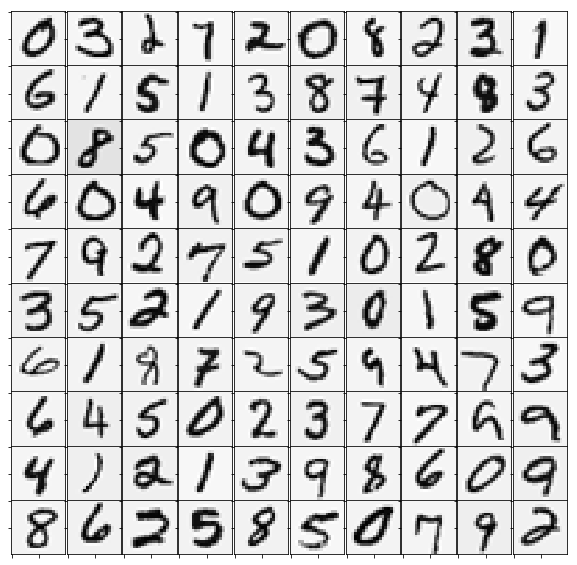

In [12]:
# =========== Part 1: Loading and Visualizing Data =============
#  We start the exercise by first loading and visualizing the dataset. 
#  You will be working with a dataset that contains handwritten digits.
#

# Load Training Data
print('Loading and Visualizing Data ...\n')
mat = scipy.io.loadmat('ex3data1.mat')
X = np.matrix(mat.get('X'))
y = mat.get('y')
m, n = X.shape

# reposition index of 0 as 0 instead of 10
y[np.flatnonzero(y==10)] = 0

# Randomly select 100 data points to display
sel = np.random.permutation(m);
sel = sel[0:100];

displayData(X[sel, :]);

### 2.2 Feedforward Propagation and Prediction
Now you will implement feedforward propagation for the neural network. You will need to complete the code in predict.m to return the neural network's prediction.

You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example i and returns the associated predictions. Similar to the one-vs-all classication strategy, the prediction from the neural network will be the label that has the largest output $(h_\theta(x))_k$.

Once you are done, ex3 nn.m will call your predict function using the loaded set of parameters for Theta1 and Theta2. You should see that the accuracy is about 97.5%. After that, an interactive sequence will launch displaying images from the training set one at a time, while the console prints out the predicted label for the displayed image. To stop the image sequence, press Ctrl-C.

In [13]:
# ================ Part 2: Loading Pameters ================
# In this part of the exercise, we load some pre-initialized 
# neural network parameters.

print('\nLoading Saved Neural Network Parameters ...\n')

# Load the weights into variables Theta1 and Theta2
mat = scipy.io.loadmat('ex3weights.mat')
Theta1 = np.matrix(mat.get('Theta1'))
Theta2 = mat.get('Theta2')

m, n = X.shape


Loading Saved Neural Network Parameters ...



In [14]:
def predict(Theta1, Theta2, X):
    #PREDICT Predict the label of an input given a trained neural network
    #   p = PREDICT(Theta1, Theta2, X) outputs the predicted label of X given the
    #   trained weights of a neural network (Theta1, Theta2)

    # Useful values
    m = X.shape[0]
    num_labels, _ = Theta2.shape

    # You need to return the following variables correctly 
    p = np.zeros((m, 1))

    X_t = np.hstack((np.ones((m, 1)), X))
    a2 = X_t * Theta1.T
    z2 = sigmoid(a2)
    z2 = np.hstack((np.ones((z2.shape[0], 1)), z2))
    a3 = z2 * Theta2.T
    z3 = sigmoid(a3)
    
    p = np.argmax(z3, axis=1)
    
    return p
    
    #[y, p] = max(z3, [], 2);

In [15]:
# ================= Part 3: Implement Predict =================
#  After training the neural network, we would like to use it to predict
#  the labels. You will now implement the "predict" function to use the
#  neural network to predict the labels of the training set. This lets
#  you compute the training set accuracy.

mat  = scipy.io.loadmat('ex3data1.mat')
X = mat['X']
y = mat['y']

pred = predict(Theta1, Theta2, X)

print('\nTraining Set Accuracy: %f\n' % (np.mean((pred+1 == y)) * 100))


Training Set Accuracy: 97.520000




Displaying Example Image


Neural Network Prediction: 5


Displaying Example Image


Neural Network Prediction: 2


Displaying Example Image


Neural Network Prediction: 0


Displaying Example Image


Neural Network Prediction: 8


Displaying Example Image


Neural Network Prediction: 4



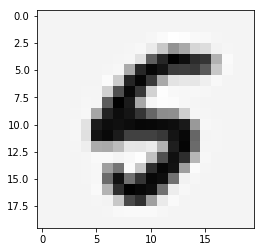

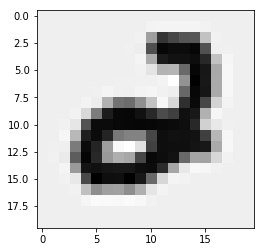

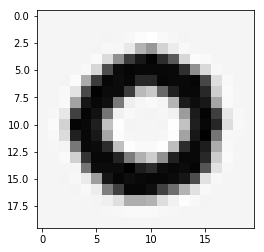

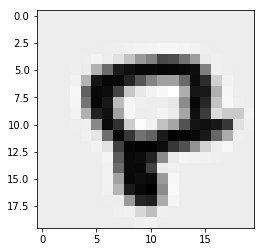

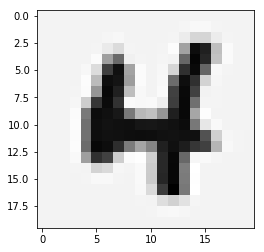

In [16]:
# To give you an idea of the network's output, you can also run
# through the examples one at the a time to see what it is predicting.

# Randomly permute examples
rp = np.random.permutation(m)

for i in range(0, 5):
    #Display 
    X_t = np.matrix(X[rp[i], :])
    print('\nDisplaying Example Image\n')
    displayData(X_t)

    pred = predict(Theta1, Theta2, X_t)
    print('\nNeural Network Prediction: %d\n' % ((pred+1) % 10))